# GetOrganelles Recovery

In [1]:
import os
import pandas as pd
import numpy as np
from Bio import SeqIO
from tqdm import tqdm

In [14]:
dec_df = pd.read_excel('../../phylotree/Release_1/Pre_release_analysis_05_Tables.xlsx',
                       sheet_name='Results_Placement_Validation')
print(dec_df.shape)
dec_df[:2]

(3182, 22)


,Sample,Source,Order,Same_Fam,Ini_Family,Ini_Genus,Ini_Species,Decision,Phylogenetic_Validation,Validation,...,Nfam_Order,Nsample_family,family,genus,species,sci_name,rank,taxonomic_status,Verdict,Comments
0,224,PAFTOL,Saxifragales,True,Saxifragaceae,Saxifraga,fortunei,Include,Confirmed,Confirmed,...,14.0,14.0,Saxifragaceae,Saxifraga,fortunei,Saxifraga fortunei,SPECIES,Accepted,NaN,NaN
1,230,PAFTOL,Malpighiales,True,Lophopyxidaceae,Lophopyxis,maingayi,Include,Confirmed,Inconclusive,...,34.0,1.0,Lophopyxidaceae,Lophopyxis,maingayi,Lophopyxis maingayi,SPECIES,Accepted,NaN,"[KL:Single rep of family, considered confirmed..."


In [15]:
paftol = dec_df[dec_df.Source=='PAFTOL']
print(paftol.shape)

(2443, 22)


In [17]:
# Latest list of samples
getorg_df = paftol[['Sample','Order', 'family', 'genus', 'species', 'sci_name']]
getorg_df['Sample'] = getorg_df.Sample.astype(int)
getorg_df[:2]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Sample,Order,family,genus,species,sci_name
0,224,Saxifragales,Saxifragaceae,Saxifraga,fortunei,Saxifraga fortunei
1,230,Malpighiales,Lophopyxidaceae,Lophopyxis,maingayi,Lophopyxis maingayi


## 1. Check logs

In [18]:
# Check logs
logs_df = pd.DataFrame(os.listdir('logs/'),columns=['file'])
logs_df['Sample_Name'] = logs_df.file.str.split('log_',expand=True)[1]
logs_df['Type'] = logs_df.Sample_Name.str.split('.',expand=True)[1]
logs_df['Sample_Name'] = logs_df.Sample_Name.str.split('.',expand=True)[0]
logs_df['Organelle'] = logs_df.Sample_Name.str.split('_',expand=True)[2]
logs_df['Sample_Name'] = logs_df.Sample_Name.str.replace('_nr','').str.replace('_pt','')
logs_df['Sample'] = logs_df.Sample_Name.str.replace('PAFTOL_','').astype(int)
logs_df = logs_df[logs_df.Organelle.isna()==False]
logs_df['filesize']=logs_df.file.apply(lambda x: os.stat('logs/' + x).st_size)
getorg_df['log_pt']=getorg_df.Sample.isin(logs_df[(logs_df.Type=='log') & (logs_df.Organelle=='pt')]['Sample'])
print(getorg_df.log_pt.sum(),'/',getorg_df.shape[0],'samples pt processed')
getorg_df['log_nr']=getorg_df.Sample.isin(logs_df[(logs_df.Type=='log') & (logs_df.Organelle=='nr')]['Sample'])
print(getorg_df.log_nr.sum(),'/',getorg_df.shape[0],'samples nr processed')
# print('continuing with processed samples only')
# getorg_df = getorg_df[getorg_df.log]

getorg_df['error_pt']=pd.merge(getorg_df,logs_df[(logs_df.Type=='err') & (logs_df.Organelle=='pt')]).filesize > 0
getorg_df['error_nr']=pd.merge(getorg_df,logs_df[(logs_df.Type=='err') & (logs_df.Organelle=='nr')]).filesize > 0
print(getorg_df.error_pt.sum(),'/',getorg_df.shape[0],'error during plastome recovery')
print(getorg_df.error_nr.sum(),'/',getorg_df.shape[0],'error during ribosomeDNA recovery')

2443 / 2443 samples pt processed
2443 / 2443 samples nr processed
94 / 2443 error during plastome recovery
7 / 2443 error during ribosomeDNA recovery


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

In [19]:
getorg_df = pd.merge(getorg_df,logs_df[['Sample_Name','Sample']].drop_duplicates())
getorg_df[:2]

,Sample,Order,family,genus,species,sci_name,log_pt,log_nr,error_pt,error_nr,Sample_Name
0,224,Saxifragales,Saxifragaceae,Saxifraga,fortunei,Saxifraga fortunei,True,True,False,False,PAFTOL_000224
1,230,Malpighiales,Lophopyxidaceae,Lophopyxis,maingayi,Lophopyxis maingayi,True,True,False,False,PAFTOL_000230


## 2. Recovery stats

In [20]:
import os.path

for idx, row in tqdm(getorg_df.iterrows(), total=getorg_df.shape[0]):
    path_fasta='fasta_pt/' + row.Sample_Name + '_pt.fasta'
    if os.path.isfile(path_fasta) :
        records = list(SeqIO.parse(path_fasta, 'fasta'))
        sumcontlen=0
        for record in records:
            sumcontlen = sumcontlen + len(record.seq)
        
        getorg_df.loc[idx,'Nseq_pt']=len(records)
        getorg_df.loc[idx,'len_pt']=sumcontlen
        
for idx, row in tqdm(getorg_df.iterrows(), total=getorg_df.shape[0]):
    path_fasta='fasta_nr/' + row.Sample_Name + '_nr.fasta'
    if os.path.isfile(path_fasta) :
        records = list(SeqIO.parse(path_fasta, 'fasta'))
        sumcontlen=0
        for record in records:
            sumcontlen = sumcontlen + len(record.seq)
        
        getorg_df.loc[idx,'Nseq_nr']=len(records)
        getorg_df.loc[idx,'len_nr']=sumcontlen

100%|█████████████████████████████████████████████████████████████████████████████| 2443/2443 [00:04<00:00, 552.75it/s]


In [22]:
getorg_df.to_csv('getorg_dec_df.csv',index=False)

In [23]:
getorg_df = pd.read_csv('getorg_dec_df.csv')

In [24]:
getorg_df

,Sample,Order,family,genus,species,sci_name,log_pt,log_nr,error_pt,error_nr,Sample_Name,Nseq_pt,len_pt,Nseq_nr,len_nr
0,224,Saxifragales,Saxifragaceae,Saxifraga,fortunei,Saxifraga fortunei,True,True,False,False,PAFTOL_000224,36.0,51751.0,3.0,4750.0
1,230,Malpighiales,Lophopyxidaceae,Lophopyxis,maingayi,Lophopyxis maingayi,True,True,False,False,PAFTOL_000230,34.0,35185.0,3.0,6384.0
2,234,Saxifragales,Saxifragaceae,Saxifraga,maderensis,Saxifraga maderensis,True,True,False,False,PAFTOL_000234,23.0,13988.0,1.0,3752.0
3,235,Fabales,Fabaceae,Berlinia,bracteosa,Berlinia bracteosa,True,True,False,False,PAFTOL_000235,6.0,2870.0,2.0,1867.0
4,237,Saxifragales,Saxifragaceae,Saxifraga,biflora,Saxifraga biflora,True,True,False,False,PAFTOL_000237,15.0,11222.0,1.0,1948.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2438,14727,Fabales,Fabaceae,Stemonocoleus,micranthus,Stemonocoleus micranthus,True,True,False,False,PAFTOL_014727,11.0,23597.0,2.0,6002.0
2439,14729,Fabales,Fabaceae,Talbotiella,velutina,Talbotiella velutina,True,True,False,False,PAFTOL_014729,7.0,4737.0,1.0,6462.0
2440,14731,Fabales,Fabaceae,Tessmannia,anomala,Tessmannia anomala,True,True,False,False,PAFTOL_014731,10.0,7753.0,2.0,5441.0
2441,14733,Fabales,Fabaceae,Tetraberlinia,korupensis,Tetraberlinia korupensis,True,True,False,False,PAFTOL_014733,15.0,13158.0,1.0,5976.0


In [40]:
print(getorg_df.Nseq_nr.notnull().sum(),'/',getorg_df.shape[0])
print(getorg_df.Nseq_pt.notnull().sum(),'/',getorg_df.shape[0])

2349 / 2443
2394 / 2443


Nseq_nr
1.0    1392
2.0     724
3.0     223
4.0      10
dtype: int64
0.1    2475.8
0.5    6789.0
0.9    9371.2
Name: len_nr, dtype: float64
0.1    5296.2
0.5    7580.5
0.9    9823.1
Name: len_nr, dtype: float64


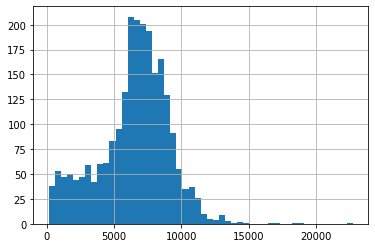

In [42]:
print(getorg_df.groupby('Nseq_nr').size())
print(getorg_df.len_nr.quantile([.1, .5, .9]))
print(getorg_df[getorg_df.Nseq_nr==1].len_nr.quantile([.1, .5, .9]))
getorg_df.len_nr.hist(bins=50)

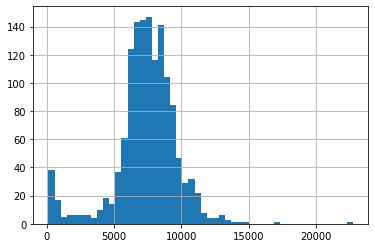

In [26]:
getorg_df[getorg_df.Nseq_nr==1].len_nr.hist(bins=50)

0.1      4972.5
0.2     10628.8
0.5     32284.5
0.9    133404.4
Name: len_pt, dtype: float64


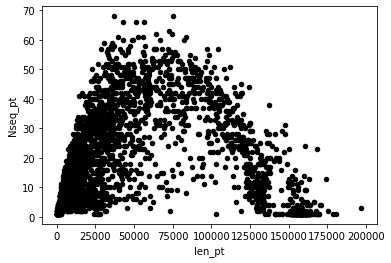

In [43]:
print(getorg_df.len_pt.quantile([.1, .2, .5, .9]))
# print(getorg_df[getorg_df.Nseq_pt==1].len_pt.quantile([.1, .5, .9]))
ax1 = getorg_df.plot.scatter(x='len_pt',y='Nseq_pt',c='black')

0.1       718.0
0.2      2004.0
0.5    155659.5
0.9    162688.5
Name: len_pt, dtype: float64
117 whole plastomes


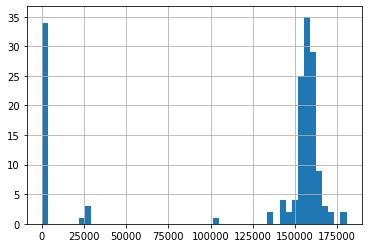

In [37]:
print(getorg_df[getorg_df.Nseq_pt==1].len_pt.quantile([.1, .2, .5, .9]))
print(sum(getorg_df[getorg_df.Nseq_pt==1].len_pt>120000), 'whole plastomes')
getorg_df[getorg_df.Nseq_pt==1].len_pt.hist(bins=50)

In [28]:
getorg_df.isna().sum()

Sample          0
Order           3
family         75
genus          75
species        75
sci_name       75
log_pt          0
log_nr          0
error_pt        0
error_nr        0
Sample_Name     0
Nseq_pt        49
len_pt         49
Nseq_nr        94
len_nr         94
dtype: int64